In [44]:
import numpy as np
import matplotlib.pyplot as plt 
import os, re
from os import listdir
from os.path import isfile, join

In [45]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, ELU, LSTM, TimeDistributed,Input
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda, MaxPooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
npzfile = np.load('df_zero_arr.npz')
print(npzfile.files)
X = npzfile['arr_0']
y = npzfile['arr_1']
print(X.shape, y.shape)

['arr_0', 'arr_1']
(36480, 128, 130) (36480,)


In [47]:
y_onehot = np.eye(10)[y]
y_onehot.shape

(36480, 10)

In [48]:
X = X.swapaxes(1,2)
X.shape

(36480, 130, 128)

In [43]:
# X = X.reshape(36480, 130, 128, 1)
# X.shape

(36480, 130, 128, 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
y_train.shape

(29184, 10)

In [53]:
BATCH_SIZE = 64
num_classes = 10
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 64
LSTM_COUNT = 96
EPOCH_COUNT = 200
NUM_HIDDEN = 64
L2_regularization = 0.001

model = Sequential()
model.add(Conv1D(input_shape=(None,128),filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(LSTM(LSTM_COUNT, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax', name='output_realtime'))



# initiate Adam optimizer
opt = Adam(lr=0.001)

# Let's train the model using Adam
model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

print(model.summary())


earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')

reducelr_callback = ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_delta=0.01,
                verbose=1, mode='min'
            )

model_history = model.fit(X_train, 
                          y_train,
                          batch_size=BATCH_SIZE,
                    epochs=EPOCH_COUNT,
                    validation_data=(X_test, y_test),
                    workers=4,
                    callbacks=[earlystop,reducelr_callback])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, None, 64)          41024     
                                                                 
 batch_normalization_25 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, None, 64)          0         
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_25 (Conv1D)          (None, None, 64)        

456/456 [==============================] - 14s 31ms/step - loss: 0.7026 - accuracy: 0.8360 - val_loss: 0.5868 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 30/200
456/456 [==============================] - 15s 32ms/step - loss: 0.7204 - accuracy: 0.8335 - val_loss: 0.6338 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 31/200
456/456 [==============================] - 15s 32ms/step - loss: 0.7156 - accuracy: 0.8317 - val_loss: 0.6019 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 32/200
456/456 [==============================] - 14s 31ms/step - loss: 0.7082 - accuracy: 0.8372 - val_loss: 0.6653 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 33/200
455/456 [============================>.] - ETA: 0s - loss: 0.7117 - accuracy: 0.8364
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
456/456 [==============================] - 14s 32ms/step - loss: 0.7117 - accuracy: 0.8364 - val_loss: 0.6066 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 34/200
456/456 [==============================] - 

456/456 [==============================] - 15s 33ms/step - loss: 0.3849 - accuracy: 0.9137 - val_loss: 0.3774 - val_accuracy: 0.9208 - lr: 6.2500e-05
Epoch 76/200
456/456 [==============================] - 15s 32ms/step - loss: 0.3783 - accuracy: 0.9166 - val_loss: 0.3611 - val_accuracy: 0.9238 - lr: 6.2500e-05
Epoch 77/200
456/456 [==============================] - 15s 32ms/step - loss: 0.3764 - accuracy: 0.9199 - val_loss: 0.3844 - val_accuracy: 0.9171 - lr: 6.2500e-05
Epoch 78/200
455/456 [============================>.] - ETA: 0s - loss: 0.3823 - accuracy: 0.9140
Epoch 78: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
456/456 [==============================] - 15s 32ms/step - loss: 0.3823 - accuracy: 0.9140 - val_loss: 0.3743 - val_accuracy: 0.9200 - lr: 6.2500e-05
Epoch 79/200
456/456 [==============================] - 15s 32ms/step - loss: 0.3727 - accuracy: 0.9174 - val_loss: 0.3616 - val_accuracy: 0.9205 - lr: 3.1250e-05
Epoch 80/200
456/456 [==============

In [54]:
model.save('./models/crnn/crnnmodel64bs.h5')

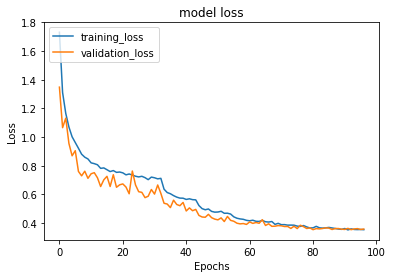

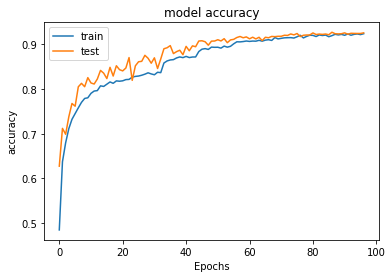

In [57]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("model loss")
plt.legend(loc='upper left')
plt.show()

training_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("model accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [59]:
dict_genres = {'blues':0, 'classical':1, 'country':2, 'disco':3, 
           'hiphop':4,'jazz':5, 'metal' :6, 'pop': 7 ,'reggae': 8 ,'rock':9}

In [60]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

228/228 [==============================] - 3s 14ms/step
(7296,) (7296,)
              precision    recall  f1-score   support

       blues       0.91      0.93      0.92       901
   classical       0.86      0.99      0.92       865
     country       0.89      0.86      0.87       500
       disco       0.99      0.97      0.98       714
      hiphop       0.95      0.88      0.91       457
        jazz       0.93      0.96      0.94       827
       metal       0.94      0.96      0.95       981
         pop       0.90      0.81      0.86       481
      reggae       0.97      0.95      0.96       660
        rock       0.92      0.85      0.89       910

    accuracy                           0.93      7296
   macro avg       0.93      0.92      0.92      7296
weighted avg       0.93      0.93      0.92      7296



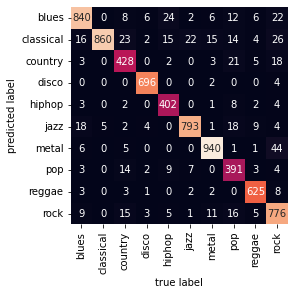

In [62]:
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');